

This Jupyter notebook implements a Multilayer Perceptron (MLP) model for hyperspectral image classification. It consists of the following main sections:

1. **Library Imports and Setup**  
   The notebook begins by importing essential libraries such as PyTorch, NumPy, Matplotlib, and scikit-learn metrics. It also sets up reproducible results by fixing random seeds, and ensures output directories are created for storing artifacts, figures, and run logs.

2. **Data Loading**  
   The notebook loads the normalized hyperspectral data cube, label maps, train/validation/test masks, and scaling parameters saved from previous preprocessing steps. Basic information about the data shape is printed for verification.

3. **Custom Dataset Definition**  
   A custom PyTorch Dataset class is defined that returns individual pixel spectra and their corresponding labels to support per-pixel classification tasks needed for spectral models like MLP.


In [2]:
# This cell imports all needed libraries and creates folders to store figures and runs
from pathlib import Path                                                                                          # import Path for file paths
import json                                                                                                       # import json to read config if needed
import pickle                                                                                                     # import pickle to load scaler saved earlier
import time                                                                                                       # import time to measure training duration
import numpy as np                                                                                                # import numpy for arrays
import matplotlib.pyplot as plt                                                                                   # import matplotlib for simple plots

import torch                                                                                                      # import torch for deep learning
import torch.nn as nn                                                                                             # import torch neural network modules
import torch.optim as optim                                                                                       # import optimizers
from torch.utils.data import Dataset, DataLoader                                                                  # import dataset and dataloader

from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, cohen_kappa_score  # import metrics

np.random.seed(42)                                                                                                # fix numpy seed for reproducibility
torch.manual_seed(42)                                                                                             # fix torch seed for reproducibility

ARTIFACTS = Path("outputs/artifacts_ip")                                                                          # set path where notebook one saved arrays and masks
FIGS = Path("outputs/figs")                                                                                       # set path to save plots
RUNS = Path("outputs/runs_mlp")                                                                                   # set path to save run logs and checkpoints
FIGS.mkdir(parents=True, exist_ok=True)                                                                           # create figs folder if missing
RUNS.mkdir(parents=True, exist_ok=True)                                                                           # create runs folder if missing

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")                                             # choose gpu if available else cpu
print("Device", DEVICE)                                                                                           # show device choice

Device cuda


In [3]:
# This cell loads the normalized cube labels masks and scaler that we saved in the first notebook
cube = np.load(ARTIFACTS / "cube_clean_norm.npy")           # load normalized cube saved earlier
labels = np.load(ARTIFACTS / "labels.npy")                  # load label map saved earlier
mask_train = np.load(ARTIFACTS / "mask_train.npy")          # load train mask
mask_val = np.load(ARTIFACTS / "mask_val.npy")              # load val mask
mask_test = np.load(ARTIFACTS / "mask_test.npy")            # load test mask
with open(ARTIFACTS / "scaler.pkl", "rb") as f:             # open scaler file
    scaler = pickle.load(f)                                 # load mean and std for reference
H, W, B = cube.shape                                        # store spatial and band dims
print("Cube", cube.shape, "Labels", labels.shape)           # quick check

Cube (145, 145, 200) Labels (145, 145)


In [4]:
# This cell builds a dataset that returns one pixel spectrum and its label for spectral models
class PixelDataset(Dataset):                                                                     # define dataset class
    """Returns spectral vector and label for each selected pixel"""                              # docstring
    def __init__(self, cube: np.ndarray, labels: np.ndarray, mask: np.ndarray):                  # init with arrays and a mask
        self.X = cube[mask]                                                                      # pick spectra for masked pixels
        self.y = labels[mask]                                                                    # pick labels for masked pixels
        idx = self.y > 0                                                                         # keep only labeled classes greater than zero
        self.X = self.X[idx]                                                                     # filter features to labeled
        self.y = self.y[idx].astype(np.int64)                                                    # filter labels to labeled and cast to long
    def __len__(self) -> int:                                                                    # return number of items
        return self.y.shape[0]                                                                   # length equals number of labeled pixels
    def __getitem__(self, i: int):                                                               # get one item
        x = self.X[i].astype(np.float32)                                                         # one spectrum as float
        y = self.y[i] - 1                                                                        # convert labels from one based to zero based
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.long)                            # return tensors

ds_train = PixelDataset(cube, labels, mask_train)                                                # create train dataset
ds_val = PixelDataset(cube, labels, mask_val)                                                    # create val dataset
ds_test = PixelDataset(cube, labels, mask_test)                                                  # create test dataset
num_classes = int(max(labels.flatten()))                                                         # compute number of classes from labels
print("Train", len(ds_train), "Val", len(ds_val), "Test", len(ds_test), "Classes", num_classes)  # summary

Train 7686 Val 513 Test 2050 Classes 16


In [5]:
# This cell builds data loaders for train val and test without class weights
BATCH = 256                                                                       # set batch size
dl_train = DataLoader(ds_train, batch_size=BATCH, shuffle=True, drop_last=False)  # build train loader with shuffle
dl_val = DataLoader(ds_val, batch_size=BATCH, shuffle=False, drop_last=False)     # build val loader without shuffle
dl_test = DataLoader(ds_test, batch_size=BATCH, shuffle=False, drop_last=False)   # build test loader without shuffle

print("Batches  train", len(dl_train), "val", len(dl_val), "test", len(dl_test))  # print loader sizes

Batches  train 31 val 3 test 9


In [6]:
# This cell defines a small MLP that maps a spectrum to a class id
class SpectralMLP(nn.Module):                                                                            # define model class
    """Two layer MLP for spectral classification"""                                                      # docstring explains model
    def __init__(self, in_dim: int, hidden1: int, hidden2: int, num_classes: int, p_drop: float = 0.3):  # init with sizes
        super().__init__()                                                                               # call base class init
        self.net = nn.Sequential(                                                                        # create a simple stack of layers
            nn.Linear(in_dim, hidden1),                                                                  # dense layer one
            nn.ReLU(inplace=True),                                                                       # activation
            nn.Dropout(p_drop),                                                                          # dropout for regularization
            nn.Linear(hidden1, hidden2),                                                                 # dense layer two
            nn.ReLU(inplace=True),                                                                       # activation
            nn.Dropout(p_drop),                                                                          # dropout for regularization
            nn.Linear(hidden2, num_classes),                                                             # final layer to logits for each class
        )                                                                                                # end of layer stack
    def forward(self, x: torch.Tensor) -> torch.Tensor:                                                  # define forward pass
        return self.net(x)                                                                               # run data through the stack

print("Input bands", B)                                                                                  # print input dimension for context
model = SpectralMLP(in_dim=B, hidden1=256, hidden2=128, num_classes=num_classes, p_drop=0.3).to(DEVICE)  # create model
print("Params", sum(p.numel() for p in model.parameters()))                                              # show parameter count

Input bands 200
Params 86416


In [7]:
                                                                                                                                                         # This cell sets up loss optimizer scheduler metrics and the training loop for one plain run
criterion = nn.CrossEntropyLoss()                                                                                                                        # use plain cross entropy without class weights
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)                                                                                   # create adam optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True)                                            # reduce lr on plateau

def metrics_from_logits(logits: torch.Tensor, targets: torch.Tensor, num_classes: int) -> dict:                                                          # define metrics helper
    """Compute accuracy precision recall f1 kappa and confusion matrix on cpu arrays"""                                                                  # docstring explains function
    preds = logits.argmax(dim=1).cpu().numpy()                                                                                                           # predicted class ids
    true = targets.cpu().numpy()                                                                                                                         # true class ids
    acc = accuracy_score(true, preds)                                                                                                                    # accuracy
    prec, rec, f1, _ = precision_recall_fscore_support(true, preds, labels=np.arange(num_classes), average="macro", zero_division=0)                     # macro metrics
    kap = cohen_kappa_score(true, preds)                                                                                                                 # kappa
    cm = confusion_matrix(true, preds, labels=np.arange(num_classes))                                                                                    # confusion matrix
    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "kappa": kap, "cm": cm}                                                                      # pack results

EPOCHS = 100                                                                                                                                             # max epochs
PATIENCE = 10                                                                                                                                            # early stopping patience
best_val_loss = float("inf")                                                                                                                             # best validation loss so far
best_state = None                                                                                                                                        # best model weights
history = []                                                                                                                                             # log per epoch
bad_epochs = 0                                                                                                                                           # counter for early stop
start_time = time.time()                                                                                                                                 # timer start

for epoch in range(1, EPOCHS + 1):                                                                                                                       # loop epochs
    model.train()                                                                                                                                        # train mode
    train_loss_sum = 0.0                                                                                                                                 # sum loss
    train_count = 0                                                                                                                                      # count samples
    for xb, yb in dl_train:                                                                                                                              # loop train batches
        xb = xb.to(DEVICE)                                                                                                                               # move features
        yb = yb.to(DEVICE)                                                                                                                               # move labels
        optimizer.zero_grad(set_to_none=True)                                                                                                            # clear grads
        logits = model(xb)                                                                                                                               # forward
        loss = criterion(logits, yb)                                                                                                                     # compute loss
        loss.backward()                                                                                                                                  # backward
        optimizer.step()                                                                                                                                 # update weights
        train_loss_sum += loss.item() * xb.size(0)                                                                                                       # add batch loss
        train_count += xb.size(0)                                                                                                                        # add batch count
    train_loss = train_loss_sum / max(1, train_count)                                                                                                    # average train loss

    model.eval()                                                                                                                                         # eval mode
    with torch.no_grad():                                                                                                                                # no grads for val
        val_logits_list = []                                                                                                                             # store logits
        val_targets_list = []                                                                                                                            # store targets
        val_loss_sum = 0.0                                                                                                                               # sum val loss
        val_count = 0                                                                                                                                    # count val samples
        for xb, yb in dl_val:                                                                                                                            # loop val batches
            xb = xb.to(DEVICE)                                                                                                                           # move features
            yb = yb.to(DEVICE)                                                                                                                           # move labels
            logits = model(xb)                                                                                                                           # forward
            loss = criterion(logits, yb)                                                                                                                 # compute loss
            val_loss_sum += loss.item() * xb.size(0)                                                                                                     # add loss
            val_count += xb.size(0)                                                                                                                      # add count
            val_logits_list.append(logits)                                                                                                               # keep logits
            val_targets_list.append(yb)                                                                                                                  # keep labels
        val_loss = val_loss_sum / max(1, val_count)                                                                                                      # average val loss
        val_logits = torch.cat(val_logits_list, dim=0)                                                                                                   # concat logits
        val_targets = torch.cat(val_targets_list, dim=0)                                                                                                 # concat targets
        val_metrics = metrics_from_logits(val_logits, val_targets, num_classes)                                                                          # compute metrics

    scheduler.step(val_loss)                                                                                                                             # step scheduler with val loss
    history.append({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss, "val_acc": val_metrics["acc"], "val_f1": val_metrics["f1"]})         # log epoch
    print(f"Epoch {epoch:03d}  train_loss {train_loss:.4f}  val_loss {val_loss:.4f}  val_acc {val_metrics['acc']:.4f}  val_f1 {val_metrics['f1']:.4f}")  # progress print

    if val_loss < best_val_loss:                                                                                                                         # check improvement
        best_val_loss = val_loss                                                                                                                         # update best loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}                                                                         # snapshot weights
        best_epoch = epoch                                                                                                                               # save epoch
        bad_epochs = 0                                                                                                                                   # reset counter
    else:                                                                                                                                                # no improvement
        bad_epochs += 1                                                                                                                                  # add one bad epoch
        if bad_epochs >= PATIENCE:                                                                                                                       # check patience
            print("Early stop at epoch", epoch, "best epoch", best_epoch)                                                                                # early stop info
            break                                                                                                                                        # stop training

train_time = time.time() - start_time                                                                                                                    # total time
print("Train time seconds", round(train_time, 2))                                                                                                        # print time

C:\Users\Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001  train_loss 1.8067  val_loss 1.3517  val_acc 0.5029  val_f1 0.2192
Epoch 002  train_loss 1.3733  val_loss 1.2057  val_acc 0.5556  val_f1 0.3883
Epoch 003  train_loss 1.2372  val_loss 1.0773  val_acc 0.5848  val_f1 0.3901
Epoch 004  train_loss 1.1255  val_loss 0.9790  val_acc 0.6316  val_f1 0.4377
Epoch 005  train_loss 1.0261  val_loss 0.9098  val_acc 0.6628  val_f1 0.4601
Epoch 006  train_loss 0.9461  val_loss 0.8556  val_acc 0.6764  val_f1 0.5011
Epoch 007  train_loss 0.9124  val_loss 0.8110  val_acc 0.7018  val_f1 0.5547
Epoch 008  train_loss 0.8393  val_loss 0.7044  val_acc 0.7407  val_f1 0.5770
Epoch 009  train_loss 0.7742  val_loss 0.6613  val_acc 0.7641  val_f1 0.6810
Epoch 010  train_loss 0.7216  val_loss 0.6378  val_acc 0.7680  val_f1 0.6886
Epoch 011  train_loss 0.7319  val_loss 0.6071  val_acc 0.7758  val_f1 0.6758
Epoch 012  train_loss 0.6815  val_loss 0.5874  val_acc 0.7719  val_f1 0.6862
Epoch 013  train_loss 0.6493  val_loss 0.5631  val_acc 0.7836  val_f1 0.6985

In [8]:
# This cell saves the best checkpoint and the per epoch history to csv
ckpt_path = RUNS / "mlp_plain_best.pth"                                                         # checkpoint path
log_path = RUNS / "mlp_plain_history.csv"                                                       # history path

if best_state is not None:                                                                      # check snapshot exists
    torch.save({"state_dict": best_state, "num_classes": num_classes, "in_dim": B}, ckpt_path)  # save checkpoint

import csv                                                                                      # import csv to write history
with open(log_path, "w", newline="") as f:                                                      # open csv
    w = csv.DictWriter(f, fieldnames=["epoch", "train_loss", "val_loss", "val_acc", "val_f1"])  # writer
    w.writeheader()                                                                             # header
    for row in history:                                                                         # rows
        w.writerow(row)                                                                         # write

print("Saved", ckpt_path.as_posix())                                                            # confirm path
print("Saved", log_path.as_posix())                                                             # confirm path

Saved outputs/runs_mlp/mlp_plain_best.pth
Saved outputs/runs_mlp/mlp_plain_history.csv


Val accuracy 0.9103313840155945
Val kappa 0.8977923883525422
Val precision macro 0.9293670329490444
Val recall macro 0.8971590325095261
Val f1 macro 0.9059305612824555


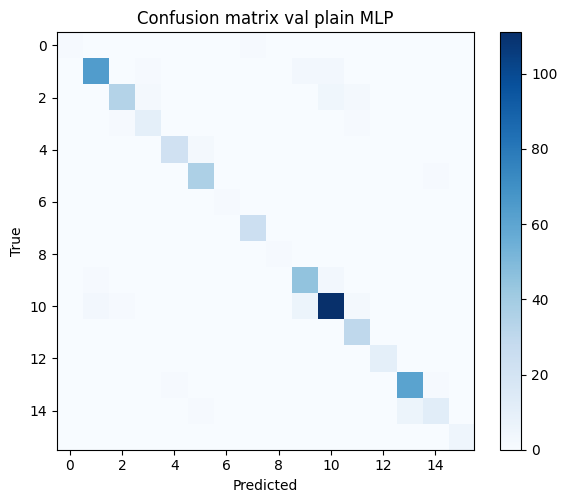

In [9]:
# This cell evaluates the best model on the validation set and prints core metrics and a confusion matrix
model.load_state_dict(best_state)                                   # load best weights
model.to(DEVICE).eval()                                             # set eval mode
with torch.no_grad():                                               # no grads
    val_logits_list = []                                            # logits list
    val_targets_list = []                                           # targets list
    for xb, yb in dl_val:                                           # loop val
        xb = xb.to(DEVICE)                                          # move features
        yb = yb.to(DEVICE)                                          # move labels
        val_logits_list.append(model(xb))                           # forward
        val_targets_list.append(yb)                                 # store labels
    val_logits = torch.cat(val_logits_list, dim=0)                  # stack logits
    val_targets = torch.cat(val_targets_list, dim=0)                # stack targets
    vm = metrics_from_logits(val_logits, val_targets, num_classes)  # compute metrics

print("Val accuracy", vm["acc"])                                    # print accuracy
print("Val kappa", vm["kappa"])                                     # print kappa
print("Val precision macro", vm["prec"])                            # print precision
print("Val recall macro", vm["rec"])                                # print recall
print("Val f1 macro", vm["f1"])                                     # print f1

cm = vm["cm"]                                                       # confusion matrix
plt.figure(figsize=(6, 5))                                          # figure
plt.imshow(cm, cmap="Blues")                                        # plot
plt.title("Confusion matrix val plain MLP")                         # title
plt.xlabel("Predicted")                                             # x label
plt.ylabel("True")                                                  # y label
plt.colorbar()                                                      # color bar
plt.tight_layout()                                                  # layout
plt.savefig(FIGS / "mlp_plain_confusion_val.png", dpi=150)          # save figure
plt.show()                                                          # show

Test accuracy 0.9219512195121952
Test kappa 0.9111719907954684
Test precision macro 0.9169264117162963
Test recall macro 0.9395694425169847
Test f1 macro 0.9260251741249226


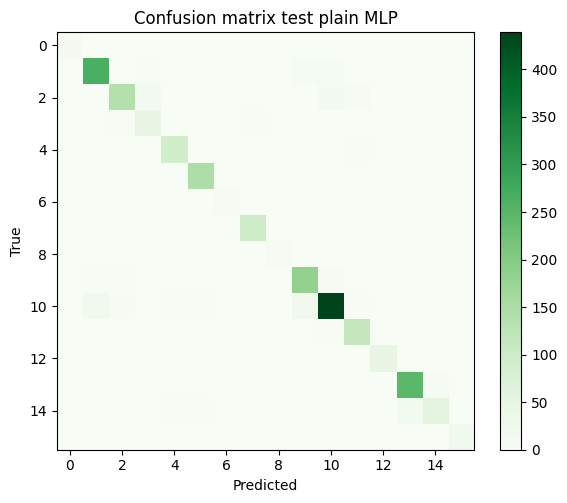

In [10]:
# This cell runs final test metrics and saves a confusion matrix figure
with torch.no_grad():                                                 # no grads
    test_logits_list = []                                             # logits list
    test_targets_list = []                                            # targets list
    for xb, yb in dl_test:                                            # loop test
        xb = xb.to(DEVICE)                                            # move features
        yb = yb.to(DEVICE)                                            # move labels
        test_logits_list.append(model(xb))                            # forward
        test_targets_list.append(yb)                                  # store labels
    test_logits = torch.cat(test_logits_list, dim=0)                  # stack logits
    test_targets = torch.cat(test_targets_list, dim=0)                # stack targets
    tm = metrics_from_logits(test_logits, test_targets, num_classes)  # compute metrics

print("Test accuracy", tm["acc"])                                     # print accuracy
print("Test kappa", tm["kappa"])                                      # print kappa
print("Test precision macro", tm["prec"])                             # print precision
print("Test recall macro", tm["rec"])                                 # print recall
print("Test f1 macro", tm["f1"])                                      # print f1

cm = tm["cm"]                                                         # confusion matrix
plt.figure(figsize=(6, 5))                                            # figure
plt.imshow(cm, cmap="Greens")                                         # plot
plt.title("Confusion matrix test plain MLP")                          # title
plt.xlabel("Predicted")                                               # x label
plt.ylabel("True")                                                    # y label
plt.colorbar()                                                        # color bar
plt.tight_layout()                                                    # layout
plt.savefig(FIGS / "mlp_plain_confusion_test.png", dpi=150)           # save figure
plt.show()                                                            # show

In [12]:
from sklearn.metrics import (
    accuracy_score,
    cohen_kappa_score,
    precision_recall_fscore_support,
    classification_report,
)

# move tensors to numpy arrays
y_true = test_targets.cpu().numpy()
y_pred = test_logits.argmax(1).cpu().numpy()

# overall metrics
overall_acc = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

# per class metrics
prec_class, rec_class, f1_class, support_class = precision_recall_fscore_support(
    y_true, y_pred, average=None, zero_division=0
)

print("Overall accuracy:", overall_acc)
print("Cohen kappa:", kappa)
print("Macro precision:", prec_macro)
print("Macro recall:", rec_macro)
print("Macro f1:", f1_macro)
print("Weighted precision:", prec_weighted)
print("Weighted recall:", rec_weighted)
print("Weighted f1:", f1_weighted)

print("\nPer class metrics")
for idx, (p, r, f1, s) in enumerate(
    zip(prec_class, rec_class, f1_class, support_class), start=1
):
    print(
        f"Class {idx:02d}: "
        f"precision={p:.4f}, recall={r:.4f}, f1={f1:.4f}, support={s}"
    )

print("\nFull classification report")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=[f"class_{i}" for i in range(1, num_classes + 1)],
        digits=4,
        zero_division=0,
    )
)


Overall accuracy: 0.9219512195121952
Cohen kappa: 0.9111719907954684
Macro precision: 0.9169264117162963
Macro recall: 0.9395694425169847
Macro f1: 0.9260251741249226
Weighted precision: 0.9229830847864825
Weighted recall: 0.9219512195121952
Weighted f1: 0.9213260454486492

Per class metrics
Class 01: precision=0.9000, recall=1.0000, f1=0.9474, support=9
Class 02: precision=0.9138, recall=0.9266, f1=0.9201, support=286
Class 03: precision=0.9200, recall=0.8313, f1=0.8734, support=166
Class 04: precision=0.7455, recall=0.8723, f1=0.8039, support=47
Class 05: precision=0.9381, recall=0.9381, f1=0.9381, support=97
Class 06: precision=0.9539, recall=0.9932, f1=0.9732, support=146
Class 07: precision=1.0000, recall=1.0000, f1=1.0000, support=5
Class 08: precision=0.9596, recall=0.9896, f1=0.9744, support=96
Class 09: precision=0.8000, recall=1.0000, f1=0.8889, support=4
Class 10: precision=0.8673, recall=0.9433, f1=0.9037, support=194
Class 11: precision=0.9400, recall=0.8941, f1=0.9165, su

In [10]:
# This cell prints and saves per class precision recall f1 and support for val and test

from sklearn.metrics import classification_report                                                                  # import the report function
import pandas as pd                                                                                                # import pandas to save tables
from pathlib import Path                                                                                           # import Path for file paths

REPORT_DIR = Path("outputs/figs")                                                                                  # choose a folder for text and csv files
REPORT_DIR.mkdir(parents=True, exist_ok=True)                                                                      # create the folder if needed

                                                                                                                   # Build y true and y pred for validation from tensors already in memory
y_val_true = val_targets.cpu().numpy()                                                                             # true class ids for val in zero based
y_val_pred = val_logits.argmax(1).cpu().numpy()                                                                    # predicted class ids for val in zero based

                                                                                                                   # Build y true and y pred for test from tensors already in memory
y_test_true = test_targets.cpu().numpy()                                                                           # true class ids for test in zero based
y_test_pred = test_logits.argmax(1).cpu().numpy()                                                                  # predicted class ids for test in zero based

                                                                                                                   # Human friendly names 1 to C since your labels are one based in the dataset
target_names = [f"class_{i}" for i in range(1, num_classes + 1)]                                                   # make names

# Text reports
val_text = classification_report(y_val_true, y_val_pred, target_names=target_names, digits=4, zero_division=0)     # val text
test_text = classification_report(y_test_true, y_test_pred, target_names=target_names, digits=4, zero_division=0)  # test text

print("Validation classification report")                                                                          # header
print(val_text)                                                                                                    # show val report
print("\nTest classification report")                                                                              # header
print(test_text)                                                                                                   # show test report

# Save text files
(REPORT_DIR / "mlp_plain_classification_report_val.txt").write_text(val_text)                                      # save val text
(REPORT_DIR / "mlp_plain_classification_report_test.txt").write_text(test_text)                                    # save test text

# Also save as csv tables
def report_to_df(y_true, y_pred, names):
    """Convert classification report dict to a dataframe"""                                                        # docstring
    rep = classification_report(y_true, y_pred, target_names=names, output_dict=True, zero_division=0)             # dict form
    df = pd.DataFrame(rep).T.reset_index().rename(columns={"index": "label"})                                      # to dataframe
    return df                                                                                                      # return table

df_val = report_to_df(y_val_true, y_val_pred, target_names)                                                        # val table
df_test = report_to_df(y_test_true, y_test_pred, target_names)                                                     # test table

df_val.to_csv(REPORT_DIR / "mlp_plain_classification_report_val.csv", index=False)                                 # save val csv
df_test.to_csv(REPORT_DIR / "mlp_plain_classification_report_test.csv", index=False)                               # save test csv

print("Saved reports in", REPORT_DIR.as_posix())                                                                   # confirm save folder

Validation classification report
              precision    recall  f1-score   support

     class_1     1.0000    0.5000    0.6667         2
     class_2     0.9265    0.8873    0.9065        71
     class_3     0.9677    0.7143    0.8219        42
     class_4     0.8333    0.8333    0.8333        12
     class_5     0.9565    0.9167    0.9362        24
     class_6     0.9250    1.0000    0.9610        37
     class_7     1.0000    1.0000    1.0000         1
     class_8     0.9600    1.0000    0.9796        24
     class_9     1.0000    1.0000    1.0000         1
    class_10     0.8000    0.8980    0.8462        49
    class_11     0.8889    0.9106    0.8996       123
    class_12     0.8286    0.9667    0.8923        30
    class_13     1.0000    1.0000    1.0000        10
    class_14     0.8841    0.9683    0.9242        63
    class_15     0.9091    0.5263    0.6667        19
    class_16     1.0000    1.0000    1.0000         5

    accuracy                         0.8967    

In [11]:
# This cell prints a short summary for the results section
print("Model  Spectral MLP plain loss")                                                           # model name
print("Params", sum(p.numel() for p in model.parameters()))                                       # parameter count
print("Val  acc", round(vm["acc"], 4), "kappa", round(vm["kappa"], 4), "f1", round(vm["f1"], 4))  # val summary
print("Test acc", round(tm["acc"], 4), "kappa", round(tm["kappa"], 4), "f1", round(tm["f1"], 4))  # test summary
print("Runs folder", RUNS.as_posix())                                                             # runs path
print("Figs folder", FIGS.as_posix())                                                             # figs path

Model  Spectral MLP plain loss
Params 86416
Val  acc 0.8967 kappa 0.882 f1 0.8959
Test acc 0.9117 kappa 0.8993 f1 0.9117
Runs folder outputs/runs_mlp
Figs folder outputs/figs


Using top ANOVA bands [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 74, 100, 101, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198]
Params with K bands 73616


C:\Users\Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


ANOVA K150  epoch 001  tl 1.9230  vl 1.5152  va 0.4990  vf 0.2033
ANOVA K150  epoch 002  tl 1.4607  vl 1.2706  va 0.5302  vf 0.3024
ANOVA K150  epoch 003  tl 1.2881  vl 1.1280  va 0.5887  vf 0.3894
ANOVA K150  epoch 004  tl 1.1658  vl 1.0149  va 0.6160  vf 0.4069
ANOVA K150  epoch 005  tl 1.0679  vl 0.9632  va 0.6238  vf 0.4496
ANOVA K150  epoch 006  tl 1.0175  vl 0.8940  va 0.6628  vf 0.4903
ANOVA K150  epoch 007  tl 0.9461  vl 0.8171  va 0.6901  vf 0.5171
ANOVA K150  epoch 008  tl 0.9210  vl 0.7846  va 0.7115  vf 0.5551
ANOVA K150  epoch 009  tl 0.8730  vl 0.7536  va 0.7368  vf 0.5864
ANOVA K150  epoch 010  tl 0.8387  vl 0.7333  va 0.7135  vf 0.5634
ANOVA K150  epoch 011  tl 0.8066  vl 0.7032  va 0.7212  vf 0.5690
ANOVA K150  epoch 012  tl 0.7871  vl 0.6970  va 0.7388  vf 0.5768
ANOVA K150  epoch 013  tl 0.7609  vl 0.6449  va 0.7622  vf 0.6262
ANOVA K150  epoch 014  tl 0.7296  vl 0.6620  va 0.7466  vf 0.6835
ANOVA K150  epoch 015  tl 0.7315  vl 0.6532  va 0.7368  vf 0.6560
ANOVA K150

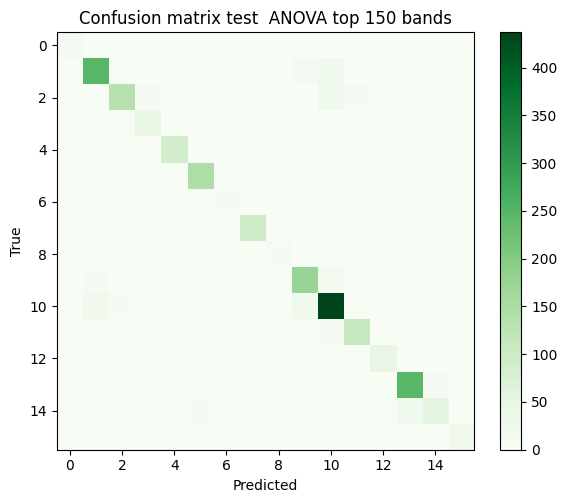

Saved checkpoint at outputs/runs_mlp/mlp_anova_top150_best.pth


In [12]:
# This cell trains the plain MLP on the top ANOVA bands and reports results

import numpy as np                                                                                               # import numpy for arrays
import torch                                                                                                     # import torch for model work
import matplotlib.pyplot as plt                                                                                  # import matplotlib for plots
from pathlib import Path                                                                                         # import Path for file paths
from sklearn.metrics import classification_report                                                                # import the report printer

# Choose how many top bands to use
K_TOP = 150                                                                                                      # number of bands to keep

# Read the ANOVA ranking table if the sorted table is not in memory
anova_csv = FIGS / "anova_band_ranking_full.csv"                                                                 # path where we saved the full ANOVA table
if "tab_anova_sorted" not in globals():                                                                          # check if the table exists in memory
    import pandas as pd                                                                                          # import pandas to read csv
    tab_anova_sorted = pd.read_csv(anova_csv)                                                                    # read the table from disk

# Pick the top K bands by ANOVA rank
bands_sel = np.array(tab_anova_sorted.sort_values("rank_F")["band"].values[:K_TOP], dtype=int)                   # band indices
bands_sel_sorted = np.sort(bands_sel)                                                                            # sorted copy for nice display
print("Using top ANOVA bands", bands_sel_sorted.tolist())                                                        # show selected bands

# Slice the cube to only the selected bands
cube_k = cube[:, :, bands_sel_sorted]                                                                            # reduce cube to K bands
Bk = cube_k.shape[2]                                                                                             # new input dimension

# Build fresh datasets on the reduced cube
class PixelDatasetBands(PixelDataset):                                                                           # subclass to reuse the parent logic
    """Dataset that reads spectra from a reduced band cube"""                                                    # docstring
    def __init__(self, cube_red: np.ndarray, labels_map: np.ndarray, mask_map: np.ndarray):                      # init method
        super().__init__(cube_red, labels_map, mask_map)                                                         # call parent to fill X and y

ds_train_k = PixelDatasetBands(cube_k, labels, mask_train)                                                       # train dataset with K bands
ds_val_k = PixelDatasetBands(cube_k, labels, mask_val)                                                           # val dataset with K bands
ds_test_k = PixelDatasetBands(cube_k, labels, mask_test)                                                         # test dataset with K bands

# Make loaders
BATCH = 256                                                                                                      # batch size
dl_train_k = DataLoader(ds_train_k, batch_size=BATCH, shuffle=True, drop_last=False)                             # train loader
dl_val_k = DataLoader(ds_val_k, batch_size=BATCH, shuffle=False, drop_last=False)                                # val loader
dl_test_k = DataLoader(ds_test_k, batch_size=BATCH, shuffle=False, drop_last=False)                              # test loader

# Define the same MLP with the new input size
model_k = SpectralMLP(in_dim=Bk, hidden1=256, hidden2=128, num_classes=num_classes, p_drop=0.3).to(DEVICE)       # model
print("Params with K bands", sum(p.numel() for p in model_k.parameters()))                                       # parameter count

# Set up loss optimizer and scheduler
criterion_k = nn.CrossEntropyLoss()                                                                              # plain cross entropy
optimizer_k = optim.Adam(model_k.parameters(), lr=1e-3, weight_decay=1e-4)                                       # adam optimizer
scheduler_k = optim.lr_scheduler.ReduceLROnPlateau(optimizer_k, mode="min", factor=0.5, patience=3, verbose=True)# scheduler

# Train with early stopping on validation loss
EPOCHS = 100                                                                                                     # max epochs
PATIENCE = 10                                                                                                    # early stop patience
best_val_loss = float("inf")                                                                                     # track best val loss
best_state_k = None                                                                                              # best weights
bad_epochs = 0                                                                                                   # patience counter

for ep in range(1, EPOCHS + 1):                                                                                  # loop epochs
    model_k.train()                                                                                              # train mode
    tr_loss_sum = 0.0                                                                                            # sum of train loss
    tr_count = 0                                                                                                 # count of samples
    for xb, yb in dl_train_k:                                                                                    # loop train batches
        xb = xb.to(DEVICE)                                                                                       # move features
        yb = yb.to(DEVICE)                                                                                       # move labels
        optimizer_k.zero_grad(set_to_none=True)                                                                  # clear grads
        logits = model_k(xb)                                                                                     # forward pass
        loss = criterion_k(logits, yb)                                                                           # compute loss
        loss.backward()                                                                                          # backward pass
        optimizer_k.step()                                                                                       # update weights
        tr_loss_sum += loss.item() * xb.size(0)                                                                  # add batch loss
        tr_count += xb.size(0)                                                                                   # add batch count
    tr_loss = tr_loss_sum / max(1, tr_count)                                                                     # average train loss

    model_k.eval()                                                                                               # eval mode
    with torch.no_grad():                                                                                        # no grads
        va_loss_sum = 0.0                                                                                        # sum val loss
        va_count = 0                                                                                             # count val samples
        v_logits = []                                                                                            # store logits
        v_targets = []                                                                                           # store targets
        for xb, yb in dl_val_k:                                                                                  # loop val batches
            xb = xb.to(DEVICE)                                                                                   # move features
            yb = yb.to(DEVICE)                                                                                   # move labels
            logits = model_k(xb)                                                                                 # forward pass
            loss = criterion_k(logits, yb)                                                                       # val loss
            va_loss_sum += loss.item() * xb.size(0)                                                              # add loss
            va_count += xb.size(0)                                                                               # add count
            v_logits.append(logits)                                                                              # keep logits
            v_targets.append(yb)                                                                                 # keep labels
        val_loss_k = va_loss_sum / max(1, va_count)                                                              # average val loss
        v_logits = torch.cat(v_logits, 0)                                                                        # stack logits
        v_targets = torch.cat(v_targets, 0)                                                                      # stack labels
        val_metrics_k = metrics_from_logits(v_logits, v_targets, num_classes)                                    # compute metrics

    scheduler_k.step(val_loss_k)                                                                                 # step scheduler
    print(f"ANOVA K{K_TOP}  epoch {ep:03d}  tl {tr_loss:.4f}  vl {val_loss_k:.4f}  va {val_metrics_k['acc']:.4f}  vf {val_metrics_k['f1']:.4f}")  # progress

    if val_loss_k < best_val_loss:                                                                               # check improvement
        best_val_loss = val_loss_k                                                                               # update best
        best_state_k = {k: v.cpu().clone() for k, v in model_k.state_dict().items()}                             # snapshot weights
        bad_epochs = 0                                                                                           # reset patience
        best_epoch_k = ep                                                                                        # store best epoch
    else:                                                                                                        # no improvement
        bad_epochs += 1                                                                                          # count bad epoch
        if bad_epochs >= PATIENCE:                                                                               # early stop
            print("Early stop at", ep, "best epoch", best_epoch_k)                                               # message
            break                                                                                                # stop loop

# Load best weights and evaluate on test
model_k.load_state_dict(best_state_k)                                                                            # load best weights
model_k.to(DEVICE).eval()                                                                                        # eval mode
with torch.no_grad():                                                                                            # no grads
    t_logits = []                                                                                                # test logits list
    t_targets = []                                                                                               # test targets list
    for xb, yb in dl_test_k:                                                                                     # loop test batches
        xb = xb.to(DEVICE)                                                                                       # move features
        yb = yb.to(DEVICE)                                                                                       # move labels
        t_logits.append(model_k(xb))                                                                             # forward
        t_targets.append(yb)                                                                                     # keep labels
    t_logits = torch.cat(t_logits, 0)                                                                            # stack logits
    t_targets = torch.cat(t_targets, 0)                                                                          # stack labels
    tm_k = metrics_from_logits(t_logits, t_targets, num_classes)                                                 # compute metrics

# Print test accuracy and report
print("Test accuracy on ANOVA bands", round(tm_k["acc"], 4))                                                     # accuracy
print("Test kappa", round(tm_k["kappa"], 4))                                                                     # kappa
print("Test f1 macro", round(tm_k["f1"], 4))                                                                     # f1 macro

y_true_test = t_targets.cpu().numpy()                                                                            # true ids
y_pred_test = t_logits.argmax(1).cpu().numpy()                                                                   # predicted ids
target_names = [f"class_{i}" for i in range(1, num_classes + 1)]                                                 # class names
print("\nClassification report on test")                                                                         # header
print(classification_report(y_true_test, y_pred_test, target_names=target_names, digits=4, zero_division=0))     # report

# Plot and save the test confusion matrix
cm_k = tm_k["cm"]                                                                                                # confusion matrix
plt.figure(figsize=(6, 5))                                                                                       # figure
plt.imshow(cm_k, cmap="Greens")                                                                                  # plot matrix
plt.title(f"Confusion matrix test  ANOVA top {K_TOP} bands")                                                     # title
plt.xlabel("Predicted")                                                                                          # x label
plt.ylabel("True")                                                                                               # y label
plt.colorbar()                                                                                                   # color bar
plt.tight_layout()                                                                                               # tidy layout
plt.savefig(FIGS / f"mlp_anova_top{K_TOP}_confusion_test.png", dpi=150)                                          # save figure
plt.show()                                                                                                       # show figure

# Save the checkpoint for this run
RUNS.mkdir(parents=True, exist_ok=True)                                                                          # ensure runs folder exists
ckpt_anova = RUNS / f"mlp_anova_top{K_TOP}_best.pth"                                                             # checkpoint path
torch.save({"state_dict": best_state_k, "num_classes": num_classes, "in_dim": Bk, "bands_sel": bands_sel_sorted}, ckpt_anova) # save weights and bands
print("Saved checkpoint at", ckpt_anova.as_posix())                                                              # done

In [13]:
# Get a seed for PCA. Read from the saved config if it exists. Fall back to 42.
import json
from pathlib import Path

CFG_PATH = Path("outputs/artifacts_ip/config_clean_preprocess.json")
if CFG_PATH.exists():
    with open(CFG_PATH, "r") as f:
        _cfg = json.load(f)
    SPLIT_SEED = int(_cfg.get("split_seed", 42))
else:
    SPLIT_SEED = 42

print("Using seed", SPLIT_SEED)


Using seed 42


Using 20 PCA components out of 20
Cumulative explained variance for these components 0.9765
Params 40336


C:\Users\Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


PCA K20  epoch 001  tl 1.7846  vl 1.3208  va 0.5302  vf 0.2992
PCA K20  epoch 002  tl 1.3469  vl 1.1744  va 0.5653  vf 0.3781
PCA K20  epoch 003  tl 1.2235  vl 1.0870  va 0.5867  vf 0.4025
PCA K20  epoch 004  tl 1.1377  vl 1.0067  va 0.6277  vf 0.4501
PCA K20  epoch 005  tl 1.0624  vl 0.9541  va 0.6238  vf 0.4640
PCA K20  epoch 006  tl 1.0022  vl 0.9072  va 0.6511  vf 0.4893
PCA K20  epoch 007  tl 0.9603  vl 0.8516  va 0.6784  vf 0.5391
PCA K20  epoch 008  tl 0.9053  vl 0.8091  va 0.6920  vf 0.6250
PCA K20  epoch 009  tl 0.8682  vl 0.7787  va 0.7057  vf 0.6380
PCA K20  epoch 010  tl 0.8355  vl 0.7499  va 0.7193  vf 0.6522
PCA K20  epoch 011  tl 0.8111  vl 0.7158  va 0.7329  vf 0.6689
PCA K20  epoch 012  tl 0.7946  vl 0.7143  va 0.7349  vf 0.6660
PCA K20  epoch 013  tl 0.7613  vl 0.6883  va 0.7407  vf 0.6638
PCA K20  epoch 014  tl 0.7461  vl 0.6782  va 0.7349  vf 0.6666
PCA K20  epoch 015  tl 0.7382  vl 0.6647  va 0.7368  vf 0.6589
PCA K20  epoch 016  tl 0.7191  vl 0.6499  va 0.7524  vf

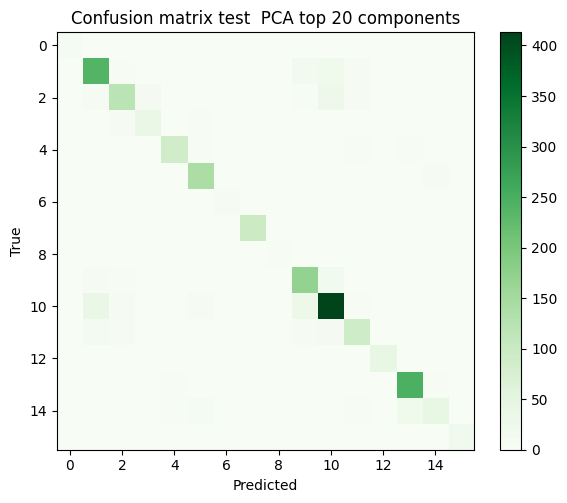

Saved checkpoint at outputs/runs_mlp/mlp_pca_top20_best.pth


In [14]:
# This cell trains the plain MLP on PCA components and reports results

import numpy as np                                                                                                            # import numpy for arrays
import pandas as pd                                                                                                           # import pandas for small tables
import torch                                                                                                                  # import torch for model work
import torch.nn as nn                                                                                                         # import torch modules
import torch.optim as optim                                                                                                   # import optimizers
import matplotlib.pyplot as plt                                                                                               # import matplotlib for plots
from sklearn.decomposition import PCA                                                                                         # import PCA
from sklearn.metrics import classification_report                                                                             # import report printer
from pathlib import Path                                                                                                      # import Path for file paths

# Choose how many PCA components to use
K_PCA = 30                                                                                                                    # number of components to keep

# Try to load PCA artifacts produced by notebook one
pca_cube_path = ARTIFACTS / "cube_pca.npy"                                                                                    # path to PCA cube
pca_obj_path = ARTIFACTS / "pca.pkl"                                                                                          # path to PCA object
need_fit_pca_now = not pca_cube_path.exists()                                                                                 # check if we need to fit PCA now

if not need_fit_pca_now:                                                                                                      # if PCA cube exists
    cube_pca_full = np.load(pca_cube_path)                                                                                    # load full PCA cube of shape H W K_full
    try:                                                                                                                      # try to read explained variance if saved
        evr = np.load(ARTIFACTS / "pca_explained_variance_ratio.npy")                                                         # load explained variance ratio
    except Exception:                                                                                                         # if not found
        evr = None                                                                                                            # set to none
else:                                                                                                                         # need to fit PCA now using normalized cube
    print("PCA artifacts not found, fitting PCA now on train pixels")                                                         # message
    H, W, B = cube.shape                                                                                                      # read shape from normalized cube in memory
    X_train_pixels = cube[mask_train].astype(np.float32)                                                                      # gather train pixels as N by B
    K_fit = max(K_PCA, 1)                                                                                                     # ensure at least one component
    pca_model = PCA(n_components=K_fit, svd_solver="auto", whiten=False, random_state=SPLIT_SEED)
    pca_model.fit(X_train_pixels)                                                                                             # fit PCA on train only
    evr = pca_model.explained_variance_ratio_                                                                                 # explained variance ratio
    X_all = cube.reshape(-1, B)                                                                                               # flatten full image
    X_all_pca = pca_model.transform(X_all)                                                                                    # transform all pixels
    cube_pca_full = X_all_pca.reshape(H, W, X_all_pca.shape[1])                                                               # reshape back to H W K_full
    
# save artifacts for reuse
    with open(pca_obj_path, "wb") as f:                                                                                       # open file for pca object
        import pickle as _pickle                                                                                              # local import for pickle
        _pickle.dump({"pca": pca_model}, f)                                                                                   # save pca object
    np.save(pca_cube_path, cube_pca_full.astype(np.float32))                                                                          # save pca cube
    np.save(ARTIFACTS / "pca_explained_variance_ratio.npy", evr)                                                                      # save variance ratio

# Select first K_PCA components
K_full = cube_pca_full.shape[2]                                                                                                       # total components available
K_use = min(K_PCA, K_full)                                                                                                            # cap by what we have
cube_pca = cube_pca_full[:, :, :K_use]                                                                                                # slice first K components
print(f"Using {K_use} PCA components out of {K_full}")                                                                                # show count
if evr is not None:                                                                                                                   # if variance ratio available
    cumvar = float(np.cumsum(evr[:K_use])[-1])                                                                                        # cumulative variance
    print("Cumulative explained variance for these components", round(cumvar, 4))                                                     # print share

# Build datasets over PCA cube
class PixelDatasetPCA(torch.utils.data.Dataset):                                                                                      # define dataset for PCA features
    """Returns PCA feature vector and label for each selected pixel"""                                                                # docstring
    def __init__(self, cube_p: np.ndarray, labels_map: np.ndarray, mask_map: np.ndarray):                                             # init
        X = cube_p[mask_map]                                                                                                          # select features for masked pixels
        y = labels_map[mask_map]                                                                                                      # select labels for masked pixels
        keep = y > 0                                                                                                                  # keep labeled classes only
        self.X = X[keep].astype(np.float32)                                                                                           # features as float
        self.y = (y[keep].astype(np.int64) - 1)                                                                                       # zero based labels
    def __len__(self):                                                                                                                # length
        return self.y.shape[0]                                                                                                        # number of items
    def __getitem__(self, i):                                                                                                         # get one
        return torch.from_numpy(self.X[i]), torch.tensor(self.y[i], dtype=torch.long)                                                 # tensors

ds_train_p = PixelDatasetPCA(cube_pca, labels, mask_train)                                                                            # train dataset
ds_val_p = PixelDatasetPCA(cube_pca, labels, mask_val)                                                                                # val dataset
ds_test_p = PixelDatasetPCA(cube_pca, labels, mask_test)                                                                              # test dataset

                                                                                                                                      # Make loaders
BATCH = 256                                                                                                                           # batch size
dl_train_p = torch.utils.data.DataLoader(ds_train_p, batch_size=BATCH, shuffle=True, drop_last=False)                                 # train loader
dl_val_p = torch.utils.data.DataLoader(ds_val_p, batch_size=BATCH, shuffle=False, drop_last=False)                                    # val loader
dl_test_p = torch.utils.data.DataLoader(ds_test_p, batch_size=BATCH, shuffle=False, drop_last=False)                                  # test loader

                                                                                                                                      # Define the same MLP but with input size equal to K_use
class SpectralMLP(nn.Module):                                                                                                         # define model
    """Two layer MLP for classification of PCA features"""                                                                            # docstring
    def __init__(self, in_dim: int, hidden1: int, hidden2: int, num_classes: int, p_drop: float = 0.3):                               # init
        super().__init__()                                                                                                            # parent init
        self.net = nn.Sequential(                                                                                                     # layer stack
            nn.Linear(in_dim, hidden1),                                                                                               # dense layer one
            nn.ReLU(inplace=True),                                                                                                    # activation
            nn.Dropout(p_drop),                                                                                                       # dropout
            nn.Linear(hidden1, hidden2),                                                                                              # dense layer two
            nn.ReLU(inplace=True),                                                                                                    # activation
            nn.Dropout(p_drop),                                                                                                       # dropout
            nn.Linear(hidden2, num_classes),                                                                                          # output layer
        )                                                                                                                             # end stack
    def forward(self, x):                                                                                                             # forward pass
        return self.net(x)                                                                                                            # run through stack

model_p = SpectralMLP(in_dim=K_use, hidden1=256, hidden2=128, num_classes=num_classes, p_drop=0.3).to(DEVICE)                         # model
print("Params", sum(p.numel() for p in model_p.parameters()))                                                                         # parameter count

                                                                                                                                      # Loss optimizer and scheduler
criterion_p = nn.CrossEntropyLoss()                                                                                                   # plain cross entropy
optimizer_p = optim.Adam(model_p.parameters(), lr=1e-3, weight_decay=1e-4)                                                            # adam optimizer
scheduler_p = optim.lr_scheduler.ReduceLROnPlateau(optimizer_p, mode="min", factor=0.5, patience=3, verbose=True)                     # scheduler

                                                                                                                                      # Helper for metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, cohen_kappa_score                      # import metrics
def metrics_from_logits(logits: torch.Tensor, targets: torch.Tensor, C: int) -> dict:                                                 # define helper
    """Return accuracy macro precision macro recall macro f1 kappa and confusion matrix"""                                            # docstring
    preds = logits.argmax(1).cpu().numpy()                                                                                            # predicted ids
    true = targets.cpu().numpy()                                                                                                      # true ids
    acc = accuracy_score(true, preds)                                                                                                 # accuracy
    prec, rec, f1, _ = precision_recall_fscore_support(true, preds, labels=np.arange(C), average="macro", zero_division=0)            # macro stats
    kap = cohen_kappa_score(true, preds)                                                                                              # kappa
    cm = confusion_matrix(true, preds, labels=np.arange(C))                                                                           # confusion matrix
    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "kappa": kap, "cm": cm}                                                   # pack results

                                                                                                                                      # Train with early stopping on validation loss
EPOCHS = 100                                                                                                                          # max epochs
PATIENCE = 10                                                                                                                         # early stopping patience
best_val_loss = float("inf")                                                                                                          # best val loss
best_state_p = None                                                                                                                   # best weights
bad_epochs = 0                                                                                                                        # counter for patience

for ep in range(1, EPOCHS + 1):                                                                                                       # loop epochs
    model_p.train()                                                                                                                   # train mode
    tr_sum = 0.0                                                                                                                      # loss sum
    tr_cnt = 0                                                                                                                        # sample count
    for xb, yb in dl_train_p:                                                                                                         # train batches
        xb = xb.to(DEVICE)                                                                                                            # move features
        yb = yb.to(DEVICE)                                                                                                            # move labels
        optimizer_p.zero_grad(set_to_none=True)                                                                                       # clear grads
        logits = model_p(xb)                                                                                                          # forward
        loss = criterion_p(logits, yb)                                                                                                # loss
        loss.backward()                                                                                                               # backward
        optimizer_p.step()                                                                                                            # step
        tr_sum += loss.item() * xb.size(0)                                                                                            # add weighted loss
        tr_cnt += xb.size(0)                                                                                                          # add count
    tr_loss = tr_sum / max(1, tr_cnt)                                                                                                 # average train loss

    model_p.eval()                                                                                                                    # eval mode
    with torch.no_grad():                                                                                                             # no grads
        va_sum = 0.0                                                                                                                  # val loss sum
        va_cnt = 0                                                                                                                    # val count
        v_logits = []                                                                                                                 # logits list
        v_targets = []                                                                                                                # targets list
        for xb, yb in dl_val_p:                                                                                                       # val batches
            xb = xb.to(DEVICE)                                                                                                        # move features
            yb = yb.to(DEVICE)                                                                                                        # move labels
            logits = model_p(xb)                                                                                                      # forward
            loss = criterion_p(logits, yb)                                                                                            # loss
            va_sum += loss.item() * xb.size(0)                                                                                        # add loss
            va_cnt += xb.size(0)                                                                                                      # add count
            v_logits.append(logits)                                                                                                   # keep logits
            v_targets.append(yb)                                                                                                      # keep targets
        val_loss = va_sum / max(1, va_cnt)                                                                                            # average val loss
        v_logits = torch.cat(v_logits, 0)                                                                                             # stack logits
        v_targets = torch.cat(v_targets, 0)                                                                                           # stack targets
        v_metrics = metrics_from_logits(v_logits, v_targets, num_classes)                                                             # compute metrics

    scheduler_p.step(val_loss)                                                                                                        # step scheduler
    print(f"PCA K{K_use}  epoch {ep:03d}  tl {tr_loss:.4f}  vl {val_loss:.4f}  va {v_metrics['acc']:.4f}  vf {v_metrics['f1']:.4f}")  # progress

    if val_loss < best_val_loss:                                                                                                      # improvement
        best_val_loss = val_loss                                                                                                      # update best loss
        best_state_p = {k: v.cpu().clone() for k, v in model_p.state_dict().items()}                                                  # snapshot weights
        bad_epochs = 0                                                                                                                # reset patience
        best_epoch_p = ep                                                                                                             # best epoch
    else:                                                                                                                             # no improvement
        bad_epochs += 1                                                                                                               # inc patience
        if bad_epochs >= PATIENCE:                                                                                                    # early stop
            print("Early stop at", ep, "best epoch", best_epoch_p)                                                                    # message
            break                                                                                                                     # stop training

                                                                                                                                      # Load best model and evaluate on test
model_p.load_state_dict(best_state_p)                                                                                                 # load best weights
model_p.to(DEVICE).eval()                                                                                                             # eval mode
with torch.no_grad():                                                                                                                 # no grads
    t_logits = []                                                                                                                     # test logits
    t_targets = []                                                                                                                    # test targets
    for xb, yb in dl_test_p:                                                                                                          # test batches
        xb = xb.to(DEVICE)                                                                                                            # move features
        yb = yb.to(DEVICE)                                                                                                            # move labels
        t_logits.append(model_p(xb))                                                                                                  # forward
        t_targets.append(yb)                                                                                                          # keep labels
    t_logits = torch.cat(t_logits, 0)                                                                                                 # stack logits
    t_targets = torch.cat(t_targets, 0)                                                                                               # stack targets
    tm_p = metrics_from_logits(t_logits, t_targets, num_classes)                                                                      # compute metrics

                                                                                                                                      # Print test accuracy kappa and f1 macro
print("Test accuracy on PCA features", round(tm_p["acc"], 4))                                                                         # accuracy
print("Test kappa", round(tm_p["kappa"], 4))                                                                                          # kappa
print("Test f1 macro", round(tm_p["f1"], 4))                                                                                          # f1 macro

                                                                                                                                      # Print classification report
y_true_test = t_targets.cpu().numpy()                                                                                                 # true ids
y_pred_test = t_logits.argmax(1).cpu().numpy()                                                                                        # predicted ids
target_names = [f"class_{i}" for i in range(1, num_classes + 1)]                                                                      # class names
print("\nClassification report on test for PCA features")                                                                             # header
print(classification_report(y_true_test, y_pred_test, target_names=target_names, digits=4, zero_division=0))                          # report

                                                                                                                                      # Plot and save test confusion matrix
cm_p = tm_p["cm"]                                                                                                                     # confusion matrix
plt.figure(figsize=(6, 5))                                                                                                            # figure
plt.imshow(cm_p, cmap="Greens")                                                                                                       # plot matrix
plt.title(f"Confusion matrix test  PCA top {K_use} components")                                                                       # title
plt.xlabel("Predicted")                                                                                                               # x label
plt.ylabel("True")                                                                                                                    # y label
plt.colorbar()                                                                                                                        # color bar
plt.tight_layout()                                                                                                                    # tidy layout
plt.savefig(FIGS / f"mlp_pca_top{K_use}_confusion_test.png", dpi=150)                                                                 # save figure
plt.show()                                                                                                                            # show figure

                                                                                                                                      # Save checkpoint for this PCA run
RUNS.mkdir(parents=True, exist_ok=True)                                                                                               # ensure runs folder exists
ckpt_pca = RUNS / f"mlp_pca_top{K_use}_best.pth"                                                                                      # checkpoint path
torch.save({"state_dict": best_state_p, "num_classes": num_classes, "in_dim": K_use}, ckpt_pca)                                       # save weights
print("Saved checkpoint at", ckpt_pca.as_posix())                                                                                     # confirm save

In [15]:
# This cell runs 5 fold stratified cross validation on train plus val and keeps test untouched

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, cohen_kappa_score

# Build train plus val arrays from your datasets
X_tv = np.concatenate([ds_train.X, ds_val.X], axis=0).astype(np.float32)                                                    # features for train plus val
y_tv = np.concatenate([ds_train.y, ds_val.y], axis=0).astype(np.int64) - 1                                                  # zero based labels

# Helper to compute metrics from logits and targets
def metrics_from_logits(logits, targets, C):
    preds = logits.argmax(1).cpu().numpy()
    true = targets.cpu().numpy()
    acc = accuracy_score(true, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(true, preds, labels=np.arange(C), average="macro", zero_division=0)
    kap = cohen_kappa_score(true, preds)
    return acc, f1, kap

# Training function for one fold
def train_one_fold(X_tr, y_tr, X_va, y_va, in_dim, num_classes, device):
    model = SpectralMLP(in_dim=in_dim, hidden1=256, hidden2=128, num_classes=num_classes, p_drop=0.3).to(device)
    crit = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    sched = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3, verbose=False)

    dl_tr = DataLoader(TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr)), batch_size=256, shuffle=True)
    dl_va = DataLoader(TensorDataset(torch.from_numpy(X_va), torch.from_numpy(y_va)), batch_size=256, shuffle=False)

    best_loss = float("inf")
    best_state = None
    bad = 0
    for ep in range(1, 101):
        model.train()
        run = 0.0
        n = 0
        for xb, yb in dl_tr:
            xb = xb.to(device)
            yb = yb.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()
            run += loss.item() * xb.size(0)
            n += xb.size(0)
        tr_loss = run / max(1, n)

        model.eval()
        with torch.no_grad():
            v_loss = 0.0
            m = 0
            all_logits = []
            all_tgts = []
            for xb, yb in dl_va:
                xb = xb.to(device)
                yb = yb.to(device)
                lg = model(xb)
                loss = crit(lg, yb)
                v_loss += loss.item() * xb.size(0)
                m += xb.size(0)
                all_logits.append(lg)
                all_tgts.append(yb)
            v_loss = v_loss / max(1, m)
        sched.step(v_loss)

        if v_loss < best_loss:
            best_loss = v_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= 10:
                break

    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        all_logits = []
        all_tgts = []
        for xb, yb in dl_va:
            xb = xb.to(device)
            yb = yb.to(device)
            all_logits.append(model(xb))
            all_tgts.append(yb)
        logits = torch.cat(all_logits, 0)
        tgts = torch.cat(all_tgts, 0)
    acc, f1, kap = metrics_from_logits(logits, tgts, num_classes)
    return acc, f1, kap

# Run 5 fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, f1s, kaps = [], [], []
for fold, (idx_tr, idx_va) in enumerate(skf.split(X_tv, y_tv), 1):
    X_tr, y_tr = X_tv[idx_tr], y_tv[idx_tr]
    X_va, y_va = X_tv[idx_va], y_tv[idx_va]
    acc, f1, kap = train_one_fold(X_tr, y_tr, X_va, y_va, in_dim=X_tv.shape[1], num_classes=num_classes, device=DEVICE)
    print(f"Fold {fold}  acc {acc:.4f}  f1 {f1:.4f}  kappa {kap:.4f}")
    accs.append(acc); f1s.append(f1); kaps.append(kap)

print("\nCV mean acc", np.mean(accs).round(4), "std", np.std(accs).round(4))
print("CV mean f1", np.mean(f1s).round(4), "std", np.std(f1s).round(4))
print("CV mean kappa", np.mean(kaps).round(4), "std", np.std(kaps).round(4))


C:\Users\Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 1  acc 0.9116  f1 0.9007  kappa 0.8993


C:\Users\Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 2  acc 0.9079  f1 0.9111  kappa 0.8952


C:\Users\Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 3  acc 0.9037  f1 0.9022  kappa 0.8900


C:\Users\Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 4  acc 0.9201  f1 0.9115  kappa 0.9088


C:\Users\Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 5  acc 0.9225  f1 0.8936  kappa 0.9115

CV mean acc 0.9132 std 0.0072
CV mean f1 0.9038 std 0.0068
CV mean kappa 0.9009 std 0.0081


Using 20 PCA components out of 20
Cumulative explained variance for these components 0.9765
Params 40336


C:\Users\Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


PCA K20  epoch 001  tl 1.7777  vl 1.3171  va 0.5302  vf 0.2687
PCA K20  epoch 002  tl 1.3378  vl 1.1590  va 0.5634  vf 0.3754
PCA K20  epoch 003  tl 1.1982  vl 1.0675  va 0.5867  vf 0.4259
PCA K20  epoch 004  tl 1.1114  vl 0.9771  va 0.6413  vf 0.4740
PCA K20  epoch 005  tl 1.0311  vl 0.9145  va 0.6550  vf 0.4918
PCA K20  epoch 006  tl 0.9737  vl 0.8588  va 0.6745  vf 0.5295
PCA K20  epoch 007  tl 0.9262  vl 0.8229  va 0.6940  vf 0.5609
PCA K20  epoch 008  tl 0.8721  vl 0.7724  va 0.7076  vf 0.5811
PCA K20  epoch 009  tl 0.8470  vl 0.7411  va 0.7173  vf 0.6558
PCA K20  epoch 010  tl 0.8082  vl 0.7173  va 0.7212  vf 0.6479
PCA K20  epoch 011  tl 0.7774  vl 0.6964  va 0.7310  vf 0.6538
PCA K20  epoch 012  tl 0.7492  vl 0.6731  va 0.7505  vf 0.6792
PCA K20  epoch 013  tl 0.7432  vl 0.6635  va 0.7544  vf 0.6745
PCA K20  epoch 014  tl 0.7372  vl 0.6607  va 0.7524  vf 0.6832
PCA K20  epoch 015  tl 0.7265  vl 0.6555  va 0.7368  vf 0.7107
PCA K20  epoch 016  tl 0.6980  vl 0.6350  va 0.7466  vf

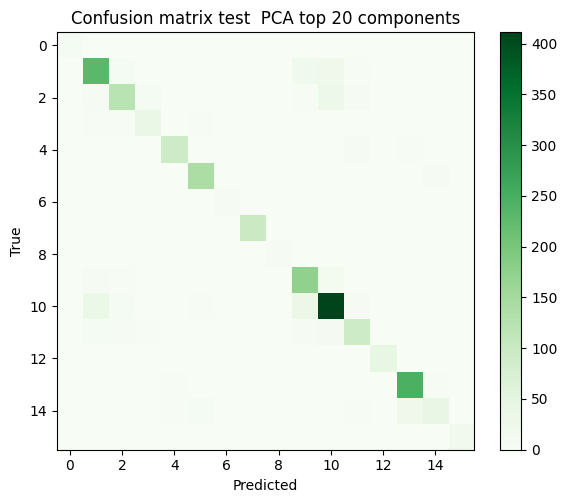

Saved checkpoint at outputs/runs_mlp/mlp_pca_top20_best.pth


In [16]:
# This cell trains the plain MLP on PCA components and reports results

import numpy as np                                                                                                                    # import numpy for arrays
import pandas as pd                                                                                                                   # import pandas for small tables
import torch                                                                                                                          # import torch for model work
import torch.nn as nn                                                                                                                 # import torch modules
import torch.optim as optim                                                                                                           # import optimizers
import matplotlib.pyplot as plt                                                                                                       # import matplotlib for plots
from sklearn.decomposition import PCA                                                                                                 # import PCA
from sklearn.metrics import classification_report                                                                                     # import report printer
from pathlib import Path                                                                                                              # import Path for file paths

# Choose how many PCA components to use
K_PCA = 20                                                                                                                            # number of components to keep

# Try to load PCA artifacts produced by notebook one
pca_cube_path = ARTIFACTS / "cube_pca.npy"                                                                                            # path to PCA cube
pca_obj_path = ARTIFACTS / "pca.pkl"                                                                                                  # path to PCA object
need_fit_pca_now = not pca_cube_path.exists()                                                                                         # check if we need to fit PCA now

if not need_fit_pca_now:                                                                                                              # if PCA cube exists
    cube_pca_full = np.load(pca_cube_path)                                                                                            # load full PCA cube of shape H W K_full
    try:                                                                                                                              # try to read explained variance if saved
        evr = np.load(ARTIFACTS / "pca_explained_variance_ratio.npy")                                                                 # load explained variance ratio
    except Exception:                                                                                                                 # if not found
        evr = None                                                                                                                    # set to none
else:                                                                                                                                 # need to fit PCA now using normalized cube
    print("PCA artifacts not found, fitting PCA now on train pixels")                                                                 # message
    H, W, B = cube.shape                                                                                                              # read shape from normalized cube in memory
    X_train_pixels = cube[mask_train].astype(np.float32)                                                                              # gather train pixels as N by B
    K_fit = max(K_PCA, 1)                                                                                                             # ensure at least one component
    pca_model = PCA(n_components=K_fit, svd_solver="auto", whiten=False, random_state=cfg.split_seed)                                 # create PCA object
    pca_model.fit(X_train_pixels)                                                                                                     # fit PCA on train only
    evr = pca_model.explained_variance_ratio_                                                                                         # explained variance ratio
    X_all = cube.reshape(-1, B)                                                                                                       # flatten full image
    X_all_pca = pca_model.transform(X_all)                                                                                            # transform all pixels
    cube_pca_full = X_all_pca.reshape(H, W, X_all_pca.shape[1])                                                                       # reshape back to H W K_full
                                                                                                                                      # save artifacts for reuse
    with open(pca_obj_path, "wb") as f:                                                                                               # open file for pca object
        import pickle as _pickle                                                                                                      # local import for pickle
        _pickle.dump({"pca": pca_model}, f)                                                                                           # save pca object
    np.save(pca_cube_path, cube_pca_full.astype(np.float32))                                                                          # save pca cube
    np.save(ARTIFACTS / "pca_explained_variance_ratio.npy", evr)                                                                      # save variance ratio

# Select first K_PCA components
K_full = cube_pca_full.shape[2]                                                                                                       # total components available
K_use = min(K_PCA, K_full)                                                                                                            # cap by what we have
cube_pca = cube_pca_full[:, :, :K_use]                                                                                                # slice first K components
print(f"Using {K_use} PCA components out of {K_full}")                                                                                # show count
if evr is not None:                                                                                                                   # if variance ratio available
    cumvar = float(np.cumsum(evr[:K_use])[-1])                                                                                        # cumulative variance
    print("Cumulative explained variance for these components", round(cumvar, 4))                                                     # print share

# Build datasets over PCA cube
class PixelDatasetPCA(torch.utils.data.Dataset):                                                                                      # define dataset for PCA features
    """Returns PCA feature vector and label for each selected pixel"""                                                                # docstring
    def __init__(self, cube_p: np.ndarray, labels_map: np.ndarray, mask_map: np.ndarray):                                             # init
        X = cube_p[mask_map]                                                                                                          # select features for masked pixels
        y = labels_map[mask_map]                                                                                                      # select labels for masked pixels
        keep = y > 0                                                                                                                  # keep labeled classes only
        self.X = X[keep].astype(np.float32)                                                                                           # features as float
        self.y = (y[keep].astype(np.int64) - 1)                                                                                       # zero based labels
    def __len__(self):                                                                                                                # length
        return self.y.shape[0]                                                                                                        # number of items
    def __getitem__(self, i):                                                                                                         # get one
        return torch.from_numpy(self.X[i]), torch.tensor(self.y[i], dtype=torch.long)                                                 # tensors

ds_train_p = PixelDatasetPCA(cube_pca, labels, mask_train)                                                                            # train dataset
ds_val_p = PixelDatasetPCA(cube_pca, labels, mask_val)                                                                                # val dataset
ds_test_p = PixelDatasetPCA(cube_pca, labels, mask_test)                                                                              # test dataset

                                                                                                                                      # Make loaders
BATCH = 256                                                                                                                           # batch size
dl_train_p = torch.utils.data.DataLoader(ds_train_p, batch_size=BATCH, shuffle=True, drop_last=False)                                 # train loader
dl_val_p = torch.utils.data.DataLoader(ds_val_p, batch_size=BATCH, shuffle=False, drop_last=False)                                    # val loader
dl_test_p = torch.utils.data.DataLoader(ds_test_p, batch_size=BATCH, shuffle=False, drop_last=False)                                  # test loader

# Define the same MLP but with input size equal to K_use
class SpectralMLP(nn.Module):                                                                                                         # define model
    """Two layer MLP for classification of PCA features"""                                                                            # docstring
    def __init__(self, in_dim: int, hidden1: int, hidden2: int, num_classes: int, p_drop: float = 0.3):                               # init
        super().__init__()                                                                                                            # parent init
        self.net = nn.Sequential(                                                                                                     # layer stack
            nn.Linear(in_dim, hidden1),                                                                                               # dense layer one
            nn.ReLU(inplace=True),                                                                                                    # activation
            nn.Dropout(p_drop),                                                                                                       # dropout
            nn.Linear(hidden1, hidden2),                                                                                              # dense layer two
            nn.ReLU(inplace=True),                                                                                                    # activation
            nn.Dropout(p_drop),                                                                                                       # dropout
            nn.Linear(hidden2, num_classes),                                                                                          # output layer
        )                                                                                                                             # end stack
    def forward(self, x):                                                                                                             # forward pass
        return self.net(x)                                                                                                            # run through stack

model_p = SpectralMLP(in_dim=K_use, hidden1=256, hidden2=128, num_classes=num_classes, p_drop=0.3).to(DEVICE)                         # model
print("Params", sum(p.numel() for p in model_p.parameters()))                                                                         # parameter count

# Loss optimizer and scheduler
criterion_p = nn.CrossEntropyLoss()                                                                                                   # plain cross entropy
optimizer_p = optim.Adam(model_p.parameters(), lr=1e-3, weight_decay=1e-4)                                                            # adam optimizer
scheduler_p = optim.lr_scheduler.ReduceLROnPlateau(optimizer_p, mode="min", factor=0.5, patience=3, verbose=True)                     # scheduler

# Helper for metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, cohen_kappa_score                      # import metrics
def metrics_from_logits(logits: torch.Tensor, targets: torch.Tensor, C: int) -> dict:                                                 # define helper
    """Return accuracy macro precision macro recall macro f1 kappa and confusion matrix"""                                            # docstring
    preds = logits.argmax(1).cpu().numpy()                                                                                            # predicted ids
    true = targets.cpu().numpy()                                                                                                      # true ids
    acc = accuracy_score(true, preds)                                                                                                 # accuracy
    prec, rec, f1, _ = precision_recall_fscore_support(true, preds, labels=np.arange(C), average="macro", zero_division=0)            # macro stats
    kap = cohen_kappa_score(true, preds)                                                                                              # kappa
    cm = confusion_matrix(true, preds, labels=np.arange(C))                                                                           # confusion matrix
    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "kappa": kap, "cm": cm}                                                   # pack results

# Train with early stopping on validation loss
EPOCHS = 100                                                                                                                          # max epochs
PATIENCE = 10                                                                                                                         # early stopping patience
best_val_loss = float("inf")                                                                                                          # best val loss
best_state_p = None                                                                                                                   # best weights
bad_epochs = 0                                                                                                                        # counter for patience

for ep in range(1, EPOCHS + 1):                                                                                                       # loop epochs
    model_p.train()                                                                                                                   # train mode
    tr_sum = 0.0                                                                                                                      # loss sum
    tr_cnt = 0                                                                                                                        # sample count
    for xb, yb in dl_train_p:                                                                                                         # train batches
        xb = xb.to(DEVICE)                                                                                                            # move features
        yb = yb.to(DEVICE)                                                                                                            # move labels
        optimizer_p.zero_grad(set_to_none=True)                                                                                       # clear grads
        logits = model_p(xb)                                                                                                          # forward
        loss = criterion_p(logits, yb)                                                                                                # loss
        loss.backward()                                                                                                               # backward
        optimizer_p.step()                                                                                                            # step
        tr_sum += loss.item() * xb.size(0)                                                                                            # add weighted loss
        tr_cnt += xb.size(0)                                                                                                          # add count
    tr_loss = tr_sum / max(1, tr_cnt)                                                                                                 # average train loss

    model_p.eval()                                                                                                                    # eval mode
    with torch.no_grad():                                                                                                             # no grads
        va_sum = 0.0                                                                                                                  # val loss sum
        va_cnt = 0                                                                                                                    # val count
        v_logits = []                                                                                                                 # logits list
        v_targets = []                                                                                                                # targets list
        for xb, yb in dl_val_p:                                                                                                       # val batches
            xb = xb.to(DEVICE)                                                                                                        # move features
            yb = yb.to(DEVICE)                                                                                                        # move labels
            logits = model_p(xb)                                                                                                      # forward
            loss = criterion_p(logits, yb)                                                                                            # loss
            va_sum += loss.item() * xb.size(0)                                                                                        # add loss
            va_cnt += xb.size(0)                                                                                                      # add count
            v_logits.append(logits)                                                                                                   # keep logits
            v_targets.append(yb)                                                                                                      # keep targets
        val_loss = va_sum / max(1, va_cnt)                                                                                            # average val loss
        v_logits = torch.cat(v_logits, 0)                                                                                             # stack logits
        v_targets = torch.cat(v_targets, 0)                                                                                           # stack targets
        v_metrics = metrics_from_logits(v_logits, v_targets, num_classes)                                                             # compute metrics

    scheduler_p.step(val_loss)                                                                                                        # step scheduler
    print(f"PCA K{K_use}  epoch {ep:03d}  tl {tr_loss:.4f}  vl {val_loss:.4f}  va {v_metrics['acc']:.4f}  vf {v_metrics['f1']:.4f}")  # progress

    if val_loss < best_val_loss:                                                                                                      # improvement
        best_val_loss = val_loss                                                                                                      # update best loss
        best_state_p = {k: v.cpu().clone() for k, v in model_p.state_dict().items()}                                                  # snapshot weights
        bad_epochs = 0                                                                                                                # reset patience
        best_epoch_p = ep                                                                                                             # best epoch
    else:                                                                                                                             # no improvement
        bad_epochs += 1                                                                                                               # inc patience
        if bad_epochs >= PATIENCE:                                                                                                    # early stop
            print("Early stop at", ep, "best epoch", best_epoch_p)                                                                    # message
            break                                                                                                                     # stop training

# Load best model and evaluate on test
model_p.load_state_dict(best_state_p)                                                                                                 # load best weights
model_p.to(DEVICE).eval()                                                                                                             # eval mode
with torch.no_grad():                                                                                                                 # no grads
    t_logits = []                                                                                                                     # test logits
    t_targets = []                                                                                                                    # test targets
    for xb, yb in dl_test_p:                                                                                                          # test batches
        xb = xb.to(DEVICE)                                                                                                            # move features
        yb = yb.to(DEVICE)                                                                                                            # move labels
        t_logits.append(model_p(xb))                                                                                                  # forward
        t_targets.append(yb)                                                                                                          # keep labels
    t_logits = torch.cat(t_logits, 0)                                                                                                 # stack logits
    t_targets = torch.cat(t_targets, 0)                                                                                               # stack targets
    tm_p = metrics_from_logits(t_logits, t_targets, num_classes)                                                                      # compute metrics

# Print test accuracy kappa and f1 macro
print("Test accuracy on PCA features", round(tm_p["acc"], 4))                                                                         # accuracy
print("Test kappa", round(tm_p["kappa"], 4))                                                                                          # kappa
print("Test f1 macro", round(tm_p["f1"], 4))                                                                                          # f1 macro

# Print classification report
y_true_test = t_targets.cpu().numpy()                                                                                                 # true ids
y_pred_test = t_logits.argmax(1).cpu().numpy()                                                                                        # predicted ids
target_names = [f"class_{i}" for i in range(1, num_classes + 1)]                                                                      # class names
print("\nClassification report on test for PCA features")                                                                             # header
print(classification_report(y_true_test, y_pred_test, target_names=target_names, digits=4, zero_division=0))                          # report

                                                                                                                                      # Plot and save test confusion matrix
cm_p = tm_p["cm"]                                                                                                                     # confusion matrix
plt.figure(figsize=(6, 5))                                                                                                            # figure
plt.imshow(cm_p, cmap="Greens")                                                                                                       # plot matrix
plt.title(f"Confusion matrix test  PCA top {K_use} components")                                                                       # title
plt.xlabel("Predicted")                                                                                                               # x label
plt.ylabel("True")                                                                                                                    # y label
plt.colorbar()                                                                                                                        # color bar
plt.tight_layout()                                                                                                                    # tidy layout
plt.savefig(FIGS / f"mlp_pca_top{K_use}_confusion_test.png", dpi=150)                                                                 # save figure
plt.show()                                                                                                                            # show figure

# Save checkpoint for this PCA run
RUNS.mkdir(parents=True, exist_ok=True)                                                                                               # ensure runs folder exists
ckpt_pca = RUNS / f"mlp_pca_top{K_use}_best.pth"                                                                                      # checkpoint path
torch.save({"state_dict": best_state_p, "num_classes": num_classes, "in_dim": K_use}, ckpt_pca)                                       # save weights
print("Saved checkpoint at", ckpt_pca.as_posix())                                                                                     # confirm save